# Car Brand Analysis

This project analyzes user comments from an automotive forum to understand the popularity and co-occurrence of car brands. Data is scraped from a forum and processed to extract brand mentions using a brand-to-model mapping. Frequencies and co-occurrence networks highlight which brands are most talked about and how they appear together in discussions.

# HW 1

In [3]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd
import numpy as np
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
import statsmodels.api as sm
import matplotlib.pyplot as plt
import regex as re

In [95]:
# Set Chrome options
options = Options()
options.add_argument("--headless=new")
options.add_argument("--disable-gpu")
options.add_argument("--no-sandbox")

driver = webdriver.Chrome(options=options)

# Open the edmunds page
url = "https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans"
driver.get(url)


In [96]:
# find all pages
pages = driver.find_elements(By.XPATH, '//span[@id="PagerBefore"]/a[contains(@class, "Pager-p")]')
last_page_num = int((pages[-1].get_attribute("href")).rsplit('/',1)[1][1:])
page_links = [url]
for i in range(2,last_page_num+1):
    page_links.append(url + f'/p{i}')

In [ ]:
#scrape ~ 8000 comments
df = pd.DataFrame(columns=['userid', 'date', 'message'])
N = len(df.index)
for page in page_links:
    if N > 8000:
        break
    driver.get(page)
    # Each comment is wrapped in .Item.Comment
    elements = driver.find_elements(By.CLASS_NAME, "Comment")

    for item in elements:
        author = item.find_element(By.CSS_SELECTOR, ".Username").text.strip()
        date = item.find_element(By.CSS_SELECTOR, ".DateCreated").text.strip()
        # Get comment body
        comment = item.find_element(By.CSS_SELECTOR, ".Message")
        driver.execute_script("arguments[0].querySelectorAll('blockquote').forEach(el => el.remove());", comment)
        text = comment.text.strip()

        df.loc[len(df.index)] = [author, date, text]
    
    N = len(df.index)


                            OLS Regression Results                            
Dep. Variable:               log_freq   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                 1.356e+06
Date:                Thu, 11 Sep 2025   Prob (F-statistic):               0.00
Time:                        13:02:28   Log-Likelihood:                 4925.1
No. Observations:               31450   AIC:                            -9846.
Df Residuals:                   31448   BIC:                            -9829.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.7063      0.011   1247.283      0.0

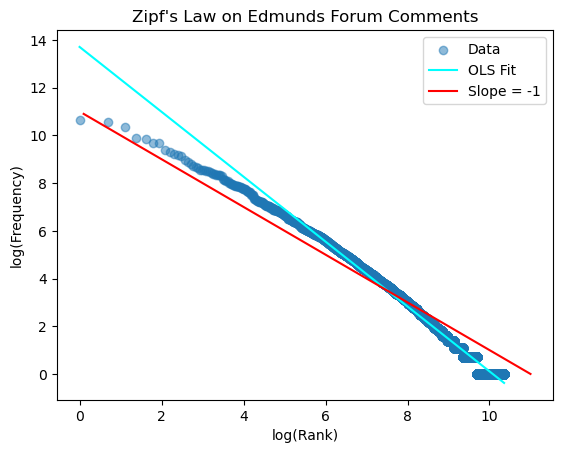

In [6]:
# get all words
text = " ".join(df['message'].dropna().tolist())
words = word_tokenize(text)

# count frequencies
freq = Counter(words)

# rank words
freq_df = pd.DataFrame(freq.items(), columns=['word', 'frequency'])
freq_df = freq_df.sort_values(by='frequency', ascending=False).reset_index(drop=True)
freq_df['rank'] = np.arange(1, len(freq_df)+1)

# log transform
freq_df['log_rank'] = np.log(freq_df['rank'])
freq_df['log_freq'] = np.log(freq_df['frequency'])

# linear regression
X = sm.add_constant(freq_df['log_rank'])
y = freq_df['log_freq']
model = sm.OLS(y, X).fit()

print(model.summary())

# plot
plt.scatter(freq_df['log_rank'], freq_df['log_freq'], alpha=0.5, label="Data")
plt.plot(freq_df['log_rank'], model.predict(X), color="cyan", label="OLS Fit")
plt.plot(np.linspace(.1,11,100), 11- np.linspace(.1,11,100),color = 'red', label = 'Slope = -1')
plt.xlabel("log(Rank)")
plt.ylabel("log(Frequency)")
plt.legend()
plt.title("Zipf's Law on Edmunds Forum Comments")
plt.show()

In [ ]:
# load brand to model dictionary
sample_data = pd.read_csv('car_forum_comments.csv', names=['userid', 'date', 'message'])
models_to_brands = pd.read_csv('car_models_and_brands.csv')
brands_dict = models_to_brands.set_index('Model').to_dict().get('Brand')

# uncomment to load scrapped data
# df = pd.read_csv('car_data.csv', dtype=str)


In [8]:
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))

# remove stop words, then find brands mentioned, dropping duplicates to avoid double counting
def filter_replace_find(s):
    s = str(s).lower()
    for token, value in brands_dict.items():
        s = s.replace(token, value)
    words = s.split()
    filtered_words = [word.lower() for word in words if word not in stop_words]
    return list(models_to_brands[models_to_brands['Brand'].isin(filtered_words)]['Brand'].drop_duplicates()), ' '.join(filtered_words)

df[['brands', 'cleaned_message']] = df['message'].map(filter_replace_find).apply(pd.Series)
df['brands']

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\frank\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\frank\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


0       [acura, audi, bmw, buick, car, chrysler, ford,...
1                                                 [honda]
2                                                      []
3                                                      []
4                                                   [bmw]
                              ...                        
8026                                                [car]
8027                         [audi, bmw, cadillac, volvo]
8028                                               [audi]
8029                                                   []
8030                                    [bmw, car, sedan]
Name: brands, Length: 8031, dtype: object

In [9]:
# count frequencies
freq = Counter(df["brands"].dropna().sum() )

brand_freq = pd.DataFrame(freq.items(), columns=['brand', 'frequency']).sort_values(by='frequency', ascending=False)
top_10 = brand_freq[~ brand_freq['brand'].isin(['car','problem','seat','sedan'])][:10]
top_10

,brand,frequency
2,bmw,2171
0,acura,679
1,audi,553
11,honda,504
13,infiniti,473
10,toyota,372
7,mercedes-benz,304
15,nissan,283
16,volvo,245
28,subaru,212


In [10]:
import itertools
N = len(df)

# get brand pairs
pair_counts = Counter()
for row in df['brands']:
    words_in_row = set(row) & set(top_10['brand'])  # keep only top words
    for a, b in itertools.combinations(sorted(words_in_row), 2):
        pair_counts[(a, b)] += 1

# compute lift
lift_matrix = pd.DataFrame(index=top_10['brand'], columns=top_10['brand'], dtype=float)
for (a, b), count in pair_counts.items():
    lift = N * count / (int(top_10[top_10['brand'] == a]['frequency'].iloc[0]) * int(top_10[top_10['brand'] == b]['frequency'].iloc[0]))
    lift_matrix.loc[a, b] = lift
    lift_matrix.loc[b, a] = lift

lift_matrix

brand,bmw,acura,audi,honda,infiniti,toyota,mercedes-benz,nissan,volvo,subaru
brand,,,,,,,,,,
bmw,NaN,1.427386,1.725855,1.203713,1.876981,1.541340,1.934788,1.124144,1.419291,0.994601
acura,1.427386,NaN,2.309928,2.792649,3.350761,1.716922,2.178785,2.131491,2.703471,2.008475
audi,1.725855,2.309928,NaN,1.296661,2.671177,1.210217,3.773966,1.436865,4.564247,1.712571
honda,1.203713,2.792649,1.296661,NaN,1.347528,3.812292,1.939399,3.828790,2.406438,1.277768
infiniti,1.876981,3.350761,2.671177,1.347528,NaN,1.141052,2.457466,2.819810,2.425551,2.002224
toyota,1.541340,1.716922,1.210217,3.812292,1.141052,NaN,1.988434,3.890545,2.995984,1.222002
mercedes-benz,1.934788,2.178785,3.773966,1.939399,2.457466,1.988434,NaN,1.400235,5.822691,1.495345
nissan,1.124144,2.131491,1.436865,3.828790,2.819810,3.890545,1.400235,NaN,2.895724,2.141743
volvo,1.419291,2.703471,4.564247,2.406438,2.425551,2.995984,5.822691,2.895724,NaN,4.174759


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\manifold\_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\manifold\_mds.py:687: UserWarning: The MDS API has changed. ``fit`` now constructs a dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


Dimension of X after MDS :  (10, 2)


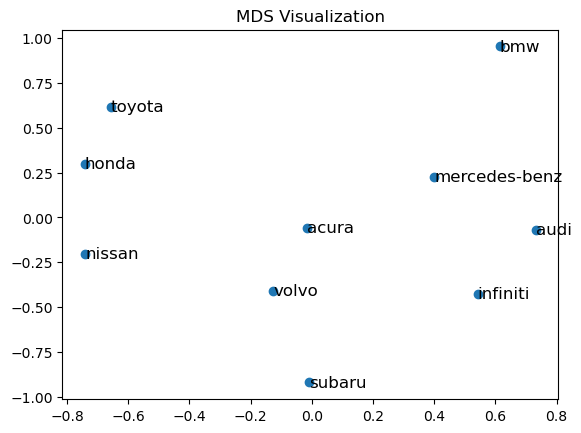

In [11]:
from sklearn.manifold import MDS

# get inverse lift for distance
X = (1 / lift_matrix).fillna(0)

mds = MDS(n_components=2, random_state=42)
X_fit = mds.fit_transform(X)

print('Dimension of X after MDS : ', X_fit.shape)

# plot the results
plt.scatter(X_fit[:, 0], X_fit[:, 1])
for i, word in enumerate(top_10['brand']):
    plt.text(X_fit[i, 0], X_fit[i, 1], word,fontsize=12, va="center")
plt.title("MDS Visualization")
plt.show()

In [12]:
word_counts = pd.DataFrame(Counter(re.findall(r'\w+', df["cleaned_message"].dropna().sum())).most_common(200), columns = ['word','frequency'])
attributes = ['performance', 'luxury', 'price', 'interior', 'engine']
# Ill be choosing the words performance, luxury, price, interior, engine after scanning the more frequent words

In [13]:
trait_matrix = pd.DataFrame(index=top_10['brand'], columns=attributes, dtype=float)

pair_counts = Counter()
for row in df['cleaned_message']:
    words_in_row = set(re.findall(r"\b[a-z0-9]+(?:-[a-z0-9]+)*\b", row))
    for a, b in itertools.product(top_10['brand'], attributes):
        if a in words_in_row and b in words_in_row:
            pair_counts[(a, b)] += 1

for (a, b), count in pair_counts.items():
    lift = N * count / (int(top_10[top_10['brand'] == a]['frequency'].iloc[0]) * int(word_counts[word_counts['word'] == b]['frequency'].iloc[0]))
    trait_matrix.loc[a, b] = lift

# the lift values between car traits and brands
trait_matrix

,performance,luxury,price,interior,engine
brand,,,,,
bmw,1.230733,1.000217,1.426246,1.025675,1.282183
acura,1.271794,1.480576,1.464592,1.350358,1.515064
audi,1.295185,1.412786,1.702932,2.146562,1.750841
honda,1.481578,1.493149,1.524692,1.137020,1.526558
infiniti,1.406850,1.396687,1.656474,1.592309,1.571778
toyota,1.829783,2.239172,1.620166,1.430445,1.603467
mercedes-benz,1.303343,1.908579,1.462146,1.184895,1.421839
nissan,1.328260,1.075850,1.331055,1.186036,2.016097
volvo,1.202540,1.899247,1.506754,1.403408,1.129114


In [ ]:
# phrases that would be mentioned to show commenter aspiration
aspiration_keywords = ["want", "would like", "planning", "plan to buy", "hope to get", "thinking of buying", "looking at", "dream", "own", "purchase", "hope", "wish"]

pair_counts = Counter()
for row in df['cleaned_message']:
    words_in_row = set(re.findall(r"\b[a-z0-9]+(?:-[a-z0-9]+)*\b", row))
    for a, b in itertools.product(top_10['brand'], aspiration_keywords):
        has_aspiration =  re.search(r"\b" + re.escape(b) + r"\b", row.lower()) is not None
        if a in words_in_row and has_aspiration:
            pair_counts[(a, b)] += 1

aspiration_matrix = pd.DataFrame(index=top_10['brand'], columns=aspiration_keywords, dtype=float)

for (a, b), count in pair_counts.items():
    lift = N * count / (int(top_10[top_10['brand'] == a]['frequency'].iloc[0]) * int(df[df['cleaned_message'].str.contains("would like")].count().iloc[0]))
    aspiration_matrix.loc[a, b] = lift

# which brands do buyers aspire to obtain using lift
aspiration_matrix

,want,would like,planning,plan to buy,hope to get,thinking of buying,looking at,dream,own,purchase,hope,wish
brand,,,,,,,,,,,,
bmw,17.139705,1.479687,0.246614,NaN,NaN,NaN,0.369922,0.493229,2.589452,2.383940,2.589452,1.109765
acura,17.741532,1.708444,0.394256,NaN,NaN,NaN,0.394256,0.394256,3.154050,2.628375,3.416888,1.839863
audi,21.138457,1.129536,0.322725,NaN,NaN,NaN,0.484087,0.968174,3.872694,1.936347,2.420434,1.774985
honda,20.183730,1.593452,0.531151,NaN,NaN,NaN,0.531151,NaN,3.186905,4.249206,3.718056,1.593452
infiniti,20.185976,2.829810,0.188654,NaN,NaN,NaN,0.377308,0.377308,3.018464,2.263848,5.659619,2.829810
toyota,25.906452,2.878495,0.479749,NaN,NaN,NaN,0.239875,0.479749,4.077867,3.358244,3.598118,3.358244
mercedes-benz,19.666557,1.467654,NaN,NaN,NaN,NaN,0.880592,0.293531,1.761184,2.054715,2.641776,1.467654
nissan,17.657479,0.945936,0.315312,NaN,NaN,NaN,0.630624,NaN,3.468433,2.522497,5.675618,2.207185
volvo,22.945714,1.456871,0.364218,NaN,NaN,NaN,NaN,NaN,2.549524,2.549524,1.092653,1.456871
